In [1]:
import mlflow

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")
mlflow.set_experiment("ths-cat-and-dog-experiment")

<Experiment: artifact_location='/Users/tharhtet/Documents/github/ML-in-Prod-batch-1/8_Experiment_Tracking/mlruns/1', creation_time=1726942019032, experiment_id='1', last_update_time=1726942019032, lifecycle_stage='active', name='ths-cat-and-dog-experiment', tags={}>

In [3]:
import os
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

2.17.0
[]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False


In [4]:

img_size = 128
batch_size = 16

root_path = r"/Users/tharhtet/Documents/github/ML-in-Prod-batch-1/5_DeepLearning/tf_best_practices/cats_and_dogs_filtered"

In [5]:
tf_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale= 1/255.0

)

train_gen = tf_generator.flow_from_directory(

    root_path+"/train",
    target_size=(img_size, img_size),
    class_mode= 'binary', #'categorical',
    batch_size=batch_size,
    shuffle=True,
    
)

test_gen = tf_generator.flow_from_directory(
    root_path+"/test",
    target_size=(img_size, img_size),
    class_mode='binary', #'categorical',
    batch_size=batch_size,
    shuffle=True,
)


#By calling .repeat(), the dataset will loop indefinitely, providing data for all the epochs.

Found 2752 images belonging to 2 classes.
Found 248 images belonging to 2 classes.


16
[0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.]
(128, 128, 3)


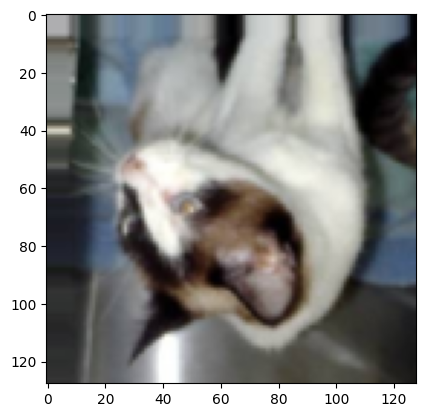

In [6]:
### test Generator
import matplotlib.pyplot as plt
import numpy as np
test_img = None
test_label = None
for image,label in test_gen:
    print(len(image))
    test_img = image
    test_label = label
    break
print(test_label)
print(test_img[0].shape)
plt.imshow(test_img[0])
plt.show()

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam,RMSprop

input_shape = (img_size,img_size,3)
model = Sequential([
    Conv2D(32,kernel_size=(3,3),activation = 'relu', padding = 'same',input_shape = input_shape),
    Conv2D(32,kernel_size=(3,3),activation = 'relu'),
    MaxPool2D(pool_size = (2,2),strides=2),
   

    Conv2D(64,kernel_size=(3,3),activation = 'relu'), 
    Conv2D(64,kernel_size=(3,3),activation = 'relu'),
    MaxPool2D(pool_size = (2,2),strides=2),

    Flatten(),
    Dense(512,activation = 'relu'),
    Dense(512,activation = 'relu'),
    Dense(1,activation = 'sigmoid')    
    
])

/opt/anaconda3/envs/dev_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()
#tf.keras.utils.plot_model(model,show_shapes=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 53824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    27,558,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,887,137 (106.38 MB)

 Trainable params: 27,887,137 (106.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import datetime

batch_size =  batch_size
epochs  = 5


base_learning_rate = 1e-3 #0.0001

from tensorflow.keras.optimizers import RMSprop


optimizer = tf.keras.optimizers.Adam()
#optimizer = RMSprop(learning_rate=0.0001)

#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
#model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])



In [10]:
num_train = len(train_gen.filenames)
num_test = len(test_gen.filenames)
steps_per_epoch=int(num_train / batch_size)
print("Number of train : ",num_train)
print(num_test/batch_size)
print(steps_per_epoch)

Number of train :  2752
15.5
172


In [11]:
image.shape

(16, 128, 128, 3)

### Prepare Model Signature

In [12]:
print(test_img.shape)
print(test_label.shape)

(16, 128, 128, 3)
(16,)


In [13]:
import cv2
from mlflow.models.signature import infer_signature

model_signature = infer_signature(test_img, model.predict(test_img))
print("model_signature : ",model_signature)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
model_signature :  inputs: 
  [Tensor('float32', (-1, 128, 128, 3))]
outputs: 
  [Tensor('float32', (-1, 1))]
params: 
  None



In [16]:
training_params = {
    "num_epochs" : epochs,
    "input_shape" : input_shape,
    "batch_size" :batch_size,
    "steps_per_epoch" : steps_per_epoch,
    
}

In [17]:


with mlflow.start_run():
 
    mlflow.set_tag("developer","tharhtet")
    mlflow.log_params(training_params)
    

    history = model.fit(train_gen, epochs=epochs,
                                validation_data=test_gen,
                                verbose=1)

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    final_valLoss = 0
    for t_acc,t_loss,v_acc,v_loss in zip(train_acc,train_loss,val_acc,val_loss):
        mlflow.log_metric("train_accuracy", t_acc)
        mlflow.log_metric("train_loss", t_loss)
        mlflow.log_metric("val_accuracy", v_acc)
        mlflow.log_metric("val_loss", v_loss)
        final_valLoss = v_loss



  

    mlflow.keras.log_model(model, "tf_bcc_model", signature=model_signature)
    

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.5037 - loss: 0.6932 - val_accuracy: 0.4597 - val_loss: 0.6939
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.4993 - loss: 0.6932 - val_accuracy: 0.4597 - val_loss: 0.6940
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - accuracy: 0.5112 - loss: 0.6931 - val_accuracy: 0.4597 - val_loss: 0.6941
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 25s 144ms/step - accuracy: 0.5049 - loss: 0.6932 - val_accuracy: 0.4597 - val_loss: 0.6938
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.4597 - val_loss: 0.6938


### Check class indices from Data Gen

In [19]:
import mlflow
logged_model = 'runs:/c1a9948a3ee64e18b6f0c4616829e696/tf_bcc_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [20]:
### test Generator
import matplotlib.pyplot as plt
import numpy as np
test_img = None
test_label = None
for image,label in test_gen:
    print(len(image))
    test_img = image
    test_label = label
    break



16


In [23]:

y_pred = loaded_model.predict(test_img)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[[0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.50219333]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]
 [0.5021758 ]]
